# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [15]:
!nvidia-smi

Tue Feb 17 09:35:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             27W /   70W |     139MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [16]:
!pip install pycuda

# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [17]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [18]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [19]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [20]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [21]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [22]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x + threadIdx.y * dim_x;
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [23]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [24]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [25]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [26]:
# Exercice 1: addition de deux vecteurs (float32)
import numpy as np

n = 1_000_000
a = np.random.randn(n).astype(np.float32)
b = np.random.randn(n).astype(np.float32)
c = np.empty_like(a)

a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

mod_vec = SourceModule("""
__global__ void vector_add(int n, const float* a, const float* b, float* c) {
    int gid = blockIdx.x * blockDim.x + threadIdx.x;
    if (gid < n) c[gid] = a[gid] + b[gid];
}
""")
vector_add = mod_vec.get_function("vector_add")

block = (256, 1, 1)
grid = ((n + block[0] - 1) // block[0], 1, 1)
vector_add(np.int32(n), a_gpu, b_gpu, c_gpu, block=block, grid=grid)

cuda.memcpy_dtoh(c, c_gpu)
print("Vector add correct:", np.allclose(c, a + b, rtol=1e-5, atol=1e-6))



Vector add correct: True


Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [27]:
# Exercice 2: addition de deux matrices carrees (float32)
rows, cols = 1024, 1024
A = np.random.randn(rows, cols).astype(np.float32)
B = np.random.randn(rows, cols).astype(np.float32)
C = np.empty_like(A)

A_gpu = cuda.mem_alloc(A.nbytes)
B_gpu = cuda.mem_alloc(B.nbytes)
C_gpu = cuda.mem_alloc(C.nbytes)
cuda.memcpy_htod(A_gpu, A)
cuda.memcpy_htod(B_gpu, B)

mod_mat = SourceModule("""
__global__ void matrix_add(int rows, int cols, const float* a, const float* b, float* c) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < cols && y < rows) {
        int idx = y * cols + x;
        c[idx] = a[idx] + b[idx];
    }
}
""")
matrix_add = mod_mat.get_function("matrix_add")

block = (16, 16, 1)
grid = ((cols + block[0] - 1) // block[0], (rows + block[1] - 1) // block[1], 1)
matrix_add(np.int32(rows), np.int32(cols), A_gpu, B_gpu, C_gpu, block=block, grid=grid)

cuda.memcpy_dtoh(C, C_gpu)
print("Matrix add correct:", np.allclose(C, A + B, rtol=1e-5, atol=1e-6))



Matrix add correct: True


# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

Time taken on GPU: 0.0041768550872802734 seconds


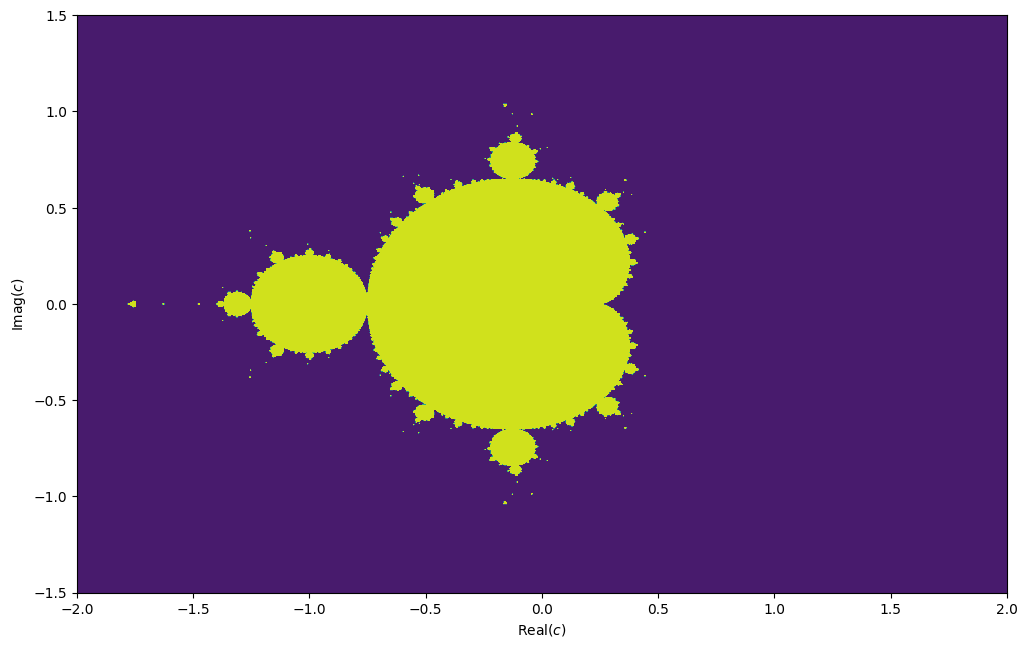

In [28]:
import pylab as plt
import numpy as np
import time

# initial values
loop = 1000      # number of iterations
div = 1500       # image width/height
x_min, x_max = -2.0, 2.0
y_min, y_max = -1.5, 1.5

color = np.empty((div, div), dtype=np.int32)
color_gpu = cuda.mem_alloc(color.nbytes)

mod_mandel = SourceModule("""
__global__ void mandelbrot_kernel(
    int width,
    int height,
    int max_iter,
    float x_min,
    float x_max,
    float y_min,
    float y_max,
    int *out
) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= width || y >= height) return;

    float cr = x_min + (x_max - x_min) * ((float)x / (float)(width - 1));
    float ci = y_min + (y_max - y_min) * ((float)y / (float)(height - 1));

    float zr = 0.0f;
    float zi = 0.0f;
    int iter = 0;

    while (iter < max_iter) {
        float zr2 = zr * zr - zi * zi + cr;
        float zi2 = 2.0f * zr * zi + ci;
        zr = zr2;
        zi = zi2;
        if (zr * zr + zi * zi > 4.0f) break;
        iter++;
    }

    int idx = y * width + x;
    if (iter == max_iter) out[idx] = max_iter + 5;
    else out[idx] = (100 * iter) / max_iter;
}
""")

mandelbrot_kernel = mod_mandel.get_function("mandelbrot_kernel")

block = (16, 16, 1)
grid = ((div + block[0] - 1) // block[0], (div + block[1] - 1) // block[1], 1)

start = time.time()
mandelbrot_kernel(
    np.int32(div),
    np.int32(div),
    np.int32(loop),
    np.float32(x_min),
    np.float32(x_max),
    np.float32(y_min),
    np.float32(y_max),
    color_gpu,
    block=block,
    grid=grid,
)
cuda.memcpy_dtoh(color, color_gpu)
end = time.time()
print(f"Time taken on GPU: {end - start} seconds")

x = np.linspace(x_min, x_max, div)
y = np.linspace(y_min, y_max, div)
c = x[np.newaxis, :] + 1j * y[:, np.newaxis]

plt.rcParams['figure.figsize'] = [12, 7.5]
plt.contourf(c.real, c.imag, color)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.savefig("plot.png")
plt.show()

